In [ ]:
import json
import pandas as pd
import torch
import requests
from tqdm import tqdm
from urllib.request import urlopen
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d
from sklearn.preprocessing import normalize

In [ ]:
(11.211419-10.319801)/0.0045,(107.096732 - 106.350199)/0.0045, 500

(198.1373333333332, 165.89622222222212)

In [ ]:
tensor_coords = torch.empty(200, 167,2)
for i in range(tensor_coords.size()[0]):
    for j in range(tensor_coords.size()[1]):
        x = 10.319801 + 0.0045*i
        y = 106.350199 + 0.0045*j
        tensor_coords[i,j] = torch.tensor([x, y])

In [ ]:
poi_data_final = set()
for x in tqdm(range(81,tensor_coords.size()[0])):
    for y in range(tensor_coords.size()[1]):
        url = "https://api.foursquare.com/v3/places/search?ll={}%2C{}&radius=5000&limit=50".format(tensor_coords[x,y][0].item(),tensor_coords[x,y][1].item())
        headers = {"accept": "application/json","Authorization": "fsq3WT5n+ZiCYSKcyDJro0w3X1BaI3p4qF4iCpzii4sZ4ZY="}
        response = requests.get(url, headers=headers).text
        data = json.loads(response)['results']
        for i in range(len(data)):
            if data[i]['categories'] != []:
                fsq_id = data[i]['fsq_id']
                fsq_name = data[i]['name']
                cat_id = data[i]['categories'][0]['id']
                cat_name = data[i]['categories'][0]['name']
                lat = data[i]['geocodes']['main']['latitude']
                lon = data[i]['geocodes']['main']['longitude']
                address = data[i]['location']['formatted_address']
                poi_data = (fsq_id, fsq_name, cat_id, cat_name, lat, lon, address)
                poi_data_final.add(poi_data)
    poi_hcm = pd.DataFrame(poi_data_final, columns =['fsq_id', 'fsq_name', 'cat_id','cat_name', 'lat', 'lon', 'address'])
    poi_hcm.to_csv('poi_hcm.csv', index=False)


100%|██████████| 119/119 [2:08:18<00:00, 64.70s/it]


In [ ]:
poi_hcm = pd.read_csv('poi_hcm.csv')
poi_hcm.drop_duplicates(subset=['fsq_id'],inplace=True)
poi_hcm.to_csv('poi_hcm.csv', index=False)

In [ ]:
osm_hcm = pd.read_csv('osm_hcm.csv')
District_urls = {}
District_json = {}
District_geo = {}
District_polygon = {}
for district, osm in zip(osm_hcm['District_en'],osm_hcm['OSM_id']):
    District_urls[district] = 'http://polygons.openstreetmap.fr/get_geojson.py?id={}&params=0'.format(osm)
    District_json[district] = json.loads(urlopen(District_urls[district]).read())
    District_geo[district] = District_json[district]['geometries'][0]['coordinates'][0][0]
    District_polygon[district] = Polygon(District_geo[district])

In [ ]:
District_list = osm_hcm['District_en']
def district_identify(lon,lat,District_polygon):
    point = Point([lon,lat])
    for district in District_list:
        if District_polygon[district].contains(point):
            return district

In [ ]:
poi_hcm = pd.read_csv('poi_hcm.csv',index_col='fsq_id')
poi_hcm['District'] = ''
for fsq_id in poi_hcm.index:
    poi_hcm['District'][fsq_id] = district_identify(poi_hcm['lon'][fsq_id],poi_hcm['lat'][fsq_id],District_polygon)

In [ ]:
poi_hcm.dropna(subset=['District'],inplace=True)

In [ ]:
def cat_id_to_par_cat(cat_id):
    par_id = int(str(cat_id)[:2])
    switcher={10:'Arts and Entertainment',
                11:'Business and Professional Services',
                12:'Community and Government',
                13:'Dining and Drinking',
                14:'Event',
                15:'Health and Medicine',
                16:'Landmarks and Outdoors',
                17:'Retail',
                18:'Sports and Recreation',
                19:'Travel and Transportation'}
    return switcher.get(par_id,'Others')

In [ ]:
poi_hcm['par_cat'] = ''
for fsq_id in poi_hcm.index:
    poi_hcm['par_cat'][fsq_id] = cat_id_to_par_cat(poi_hcm['cat_id'][fsq_id])

In [ ]:
poi_hcm.reset_index(inplace=True)
poi_hcm.to_csv('poi_hcm.csv', index=False)

In [ ]:
osm_hcm = pd.read_csv('osm_hcm.csv')
poi_hcm = pd.read_csv('poi_hcm_final.csv')

In [ ]:
osm_hcm

,District_en,District_vn,OSM_id
0,District_1,Quận 1,2587287
1,District_3,Quận 3,3819816
2,District_4,Quận 4,2778323
3,District_5,Quận 5,3820432
4,District_6,Quận 6,6228792
5,District_7,Quận 7,2764875
6,District_8,Quận 8,6888445
7,District_10,Quận 10,6228121
8,District_11,Quận 11,6846181
9,District_12,Quận 12,6923167


In [ ]:
poi_hcm_coffee = poi_hcm[(poi_hcm['cat_id'] == 13032) | (poi_hcm['cat_id'] == 13035)][['District','fsq_id']]

In [ ]:
poi_hcm_coffee_final = poi_hcm_coffee.groupby('District').count()

In [ ]:
add_rows = pd.DataFrame({'District':['District_4','District_11'],'fsq_id':[2,2]})

In [ ]:
poi_hcm_coffee_final.reset_index(inplace=True)

In [ ]:
poi_hcm_coffee_final = poi_hcm_coffee_final.append(add_rows,ignore_index=True)

In [ ]:
poi_hcm_coffee_final

,District,fsq_id
0,Binh_Chanh_District,7
1,Binh_Tan_District,14
2,Binh_Thanh_District,5
3,Can_Gio_District,4
4,Cu_Chi_District,7
5,District_1,18
6,District_10,3
7,District_12,7
8,District_3,4
9,District_5,4


In [ ]:
poi_hcm_coffee_final.rename(columns={'District': 'District_en', 'fsq_id': 'no_coffee_shop'}, inplace=True)

In [ ]:
main_table_1 = pd.merge(osm_hcm, poi_hcm_coffee_final, on=["District_en"])

In [ ]:
tables_hcm = pd.read_html(requests.get("https://rentapartment.vn/dan-so-dien-tich-quan-tphcm/").content)

In [ ]:
table_1 = tables_hcm[0]
table_1.drop('Số Phường/Xã',axis=1,inplace=True)
table_1.rename(columns={'Quận': 'District_vn', 'Dân số (người)': 'pop(person)',
                        'Diện tích (km²)': 'area(km2)', table_1.columns[3]: 'den(person_per_km2)'}, inplace=True)

In [ ]:
table_1

,District_vn,pop(person),area(km2),den(person_per_km2)
0,Quận 1,205180,7.73,26543
1,Quận 2,168680,49.74,3391
2,Quận 3,196433,4.92,39925
3,Quận 4,203060,4.18,48578
4,Quận 5,187510,4.27,43913
5,Quận 6,258945,7.19,36014
6,Quận 7,324620,35.69,9095
7,Quận 8,451290,19.18,23529
8,Quận 9,397000,114.00,3482
9,Quận 10,372450,5.72,65113


In [ ]:
table_2 = tables_hcm[1]
table_2

,Huyện,Dân số (người),Diện tích (km²),Mật độ dân số (người / km²)
0,Huyện Nhà Bè,175360,100,7
1,Huyện Hóc Môn,422471,109,12
2,Huyện Củ Chi,403038,435,21
3,Huyện Cần Giờ,74960,704,7
4,Huyện Bình Chánh,680000,253,16


In [ ]:
table_2 = tables_hcm[1]
table_2.rename(columns={'Huyện': 'District_vn', 'Dân số (người)': 'pop(person)',
                        'Diện tích (km²)': 'area(km2)', table_2.columns[3]: 'den(person_per_km2)'}, inplace=True)

In [ ]:
table_2

,District_vn,pop(person),area(km2),den(person_per_km2)
0,Huyện Nhà Bè,175360,100,7
1,Huyện Hóc Môn,422471,109,12
2,Huyện Củ Chi,403038,435,21
3,Huyện Cần Giờ,74960,704,7
4,Huyện Bình Chánh,680000,253,16


In [ ]:
table_2['District_vn'] = table_2["District_vn"].apply(lambda x: x[6:])

In [ ]:
table_2

,District_vn,pop(person),area(km2),den(person_per_km2)
0,Nhà Bè,175360,100,7
1,Hóc Môn,422471,109,12
2,Củ Chi,403038,435,21
3,Cần Giờ,74960,704,7
4,Bình Chánh,680000,253,16


In [ ]:
main_table_2 = pd.concat([table_1, table_2], ignore_index=True, axis=0)
main_table_2

,District_vn,pop(person),area(km2),den(person_per_km2)
0,Quận 1,205180,7.73,26543
1,Quận 2,168680,49.74,3391
2,Quận 3,196433,4.92,39925
3,Quận 4,203060,4.18,48578
4,Quận 5,187510,4.27,43913
5,Quận 6,258945,7.19,36014
6,Quận 7,324620,35.69,9095
7,Quận 8,451290,19.18,23529
8,Quận 9,397000,114.00,3482
9,Quận 10,372450,5.72,65113


In [ ]:
main_table_3 = pd.merge(main_table_1, main_table_2, on="District_vn", how="left")

In [ ]:
main_table_3

,District_en,District_vn,OSM_id,no_coffee_shop,pop(person),area(km2),den(person_per_km2)
0,District_1,Quận 1,2587287,180,205180,7.73,26543
1,District_3,Quận 3,3819816,40,196433,4.92,39925
2,District_4,Quận 4,2778323,20,203060,4.18,48578
3,District_5,Quận 5,3820432,40,187510,4.27,43913
4,District_6,Quận 6,6228792,20,258945,7.19,36014
5,District_7,Quận 7,2764875,260,324620,35.69,9095
6,District_8,Quận 8,6888445,70,451290,19.18,23529
7,District_10,Quận 10,6228121,30,372450,5.72,65113
8,District_11,Quận 11,6846181,20,332536,5.14,64695
9,District_12,Quận 12,6923167,70,520175,52.78,9855


In [ ]:
main_table_3['no_coffee_shop'] = main_table_3['no_coffee_shop'].apply(lambda x: 10*x)

In [ ]:
main_table_3.to_csv('osm_hcm_final.csv', index=False)

In [ ]:
data = requests.get("https://mogi.vn/gia-nha-dat").text
soup = BeautifulSoup(data, 'html.parser')

In [ ]:
hcm_house_price = []
for row in soup.find("div", class_="mt-table").find_all("div", class_="mt-row"):
    district = row.a.text.strip()
    price = row.span.text
    hcm_house_price.append([district,price])

In [ ]:
hcm_house_price = pd.DataFrame(hcm_house_price, columns =['District_vn', 'avg_house_price'])

In [ ]:
def fix_AHP(x):
    return float(x.replace(",",".")[:len(x)-9])

In [ ]:
hcm_house_price['avg_house_price'] = hcm_house_price['avg_house_price'].apply(lambda x: fix_AHP(x))

In [ ]:
Thu_Duc_ahp = (5020*38.2+ 11362*28.5 + 4726*23.3)/(5020+ 11362 + 4726)

In [ ]:
Thu_Duc = pd.DataFrame({'District_vn':["Thủ Đức"] , 'avg_house_price': [Thu_Duc_ahp]})

In [ ]:
hcm_house_price = hcm_house_price.append(Thu_Duc,ignore_index = True)

In [ ]:
hcm_house_price.reset_index(drop=True, inplace=True)

In [ ]:
hcm_house_price

,District_vn,avg_house_price
0,Quận 1,28.300000
1,Quận 3,28.100000
2,Quận 4,26.800000
3,Quận 5,28.800000
4,Quận 6,25.900000
5,Quận 7,26.700000
6,Quận 8,24.500000
7,Quận 10,25.700000
8,Quận 11,26.700000
9,Quận 12,25.700000


In [ ]:
hcm_house_price.drop([1,8,18],inplace=True)

In [ ]:
for i in range(10,16):
    hcm_house_price.at[i,'District_vn'] = hcm_house_price.at[i,'District_vn'][5:]
for i in range(16,21):
    hcm_house_price.at[i,'District_vn'] = hcm_house_price.at[i,'District_vn'][6:]

In [ ]:
hcm_house_price

,District_vn,avg_house_price
0,Quận 1,28.300000
1,Quận 3,28.100000
2,Quận 4,26.800000
3,Quận 5,28.800000
4,Quận 6,25.900000
5,Quận 7,26.700000
6,Quận 8,24.500000
7,Quận 10,25.700000
8,Quận 11,26.700000
9,Quận 12,25.700000


In [ ]:
main_table_4 = pd.merge(main_table_3, hcm_house_price, on="District_vn", how="left")

In [ ]:
main_table_4

,District_en,District_vn,OSM_id,no_coffee_shop,pop(person),area(km2),den(person_per_km2),avg_house_price
0,District_1,Quận 1,2587287,180,205180,7.73,26543,28.300000
1,District_3,Quận 3,3819816,40,196433,4.92,39925,28.100000
2,District_4,Quận 4,2778323,20,203060,4.18,48578,26.800000
3,District_5,Quận 5,3820432,40,187510,4.27,43913,28.800000
4,District_6,Quận 6,6228792,20,258945,7.19,36014,25.900000
5,District_7,Quận 7,2764875,260,324620,35.69,9095,26.700000
6,District_8,Quận 8,6888445,70,451290,19.18,23529,24.500000
7,District_10,Quận 10,6228121,30,372450,5.72,65113,25.700000
8,District_11,Quận 11,6846181,20,332536,5.14,64695,26.700000
9,District_12,Quận 12,6923167,70,520175,52.78,9855,25.700000


In [ ]:
main_table_4['coffee_den(shop_per_km2)'] = ''
for i in main_table_4.index:
    main_table_4.at[i,'coffee_den(shop_per_km2)'] = main_table_4.at[i,'no_coffee_shop']/main_table_4.at[i,'area(km2)']

In [ ]:
main_table_4.to_csv('osm_hcm_final.csv',index=False)

In [ ]:
main_table_4

,District_en,District_vn,OSM_id,no_coffee_shop,pop(person),area(km2),den(person_per_km2),avg_house_price,coffee_den(shop_per_km2)
0,District_1,Quận 1,2587287,180,205180,7.73,26543,28.300000,23.285899
1,District_3,Quận 3,3819816,40,196433,4.92,39925,28.100000,8.130081
2,District_4,Quận 4,2778323,20,203060,4.18,48578,26.800000,4.784689
3,District_5,Quận 5,3820432,40,187510,4.27,43913,28.800000,9.367681
4,District_6,Quận 6,6228792,20,258945,7.19,36014,25.900000,2.781641
5,District_7,Quận 7,2764875,260,324620,35.69,9095,26.700000,7.284954
6,District_8,Quận 8,6888445,70,451290,19.18,23529,24.500000,3.649635
7,District_10,Quận 10,6228121,30,372450,5.72,65113,25.700000,5.244755
8,District_11,Quận 11,6846181,20,332536,5.14,64695,26.700000,3.891051
9,District_12,Quận 12,6923167,70,520175,52.78,9855,25.700000,1.32626


In [ ]:
X_df = main_table_4[['coffee_den(shop_per_km2)','den(person_per_km2)','avg_house_price', 'District_vn']]

In [ ]:
X_df_norm = X_df.copy()

In [ ]:
X_df_norm.iloc[:,0:-1] = normalize(X_df_norm.iloc[:,0:-1], axis=0)

In [ ]:
import plotly.express as px
df = px.data.iris()
fig = px.scatter_3d(X_df_norm, x='coffee_den(shop_per_km2)', y='den(person_per_km2)', z='avg_house_price',
              color='District_vn')
fig.show()

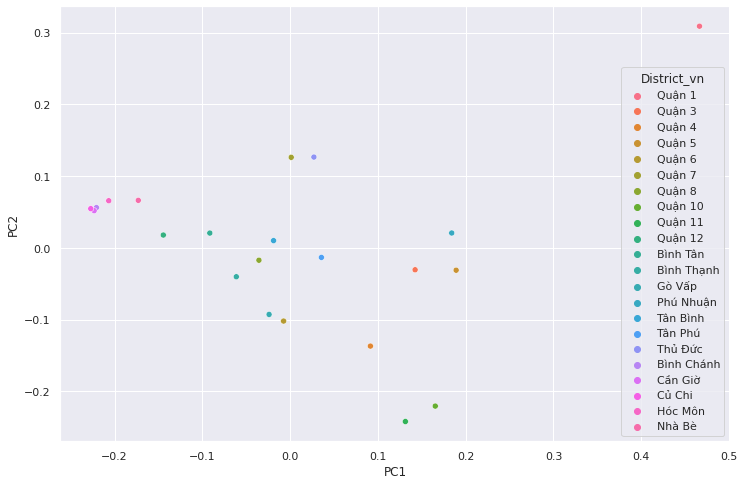

In [ ]:
# Find pinciple components by PCA and plot them
sns.set(rc={'figure.figsize':(12,8)})
principalComponents = PCA(n_components=2).fit_transform(X_df_norm.iloc[:,0:-1])
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
PCA_df = pd.concat([principalDf, X_df_norm.iloc[:,-1]], axis = 1)
fig = sns.scatterplot(data=PCA_df, x="PC1", y="PC2", hue="District_vn")

In [ ]:
for i, txt in enumerate(df_label):
    fig.annotate(txt, (principalDf['PC2'][i], principalDf['PC1'][i]))

In [ ]:
fig